# **Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

# **Load cifar100 datasets**

In [2]:
(full_train_x, full_train_y), (test_x, test_y) = keras.datasets.cifar100.load_data()
full_train_x.shape, full_train_y.shape, test_x.shape, test_y.shape

169017344/169001437 [==============================] - 3s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
np.unique(full_train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
full_train_y[0]

array([19])

# **Create cross-validation set**

In [5]:
train_x, val_x, train_y, val_y = train_test_split(full_train_x, full_train_y, test_size = 0.2)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

# **Resize each image to 64 x 64 (for ResNet only)**

In [ ]:
new_train_x = np.zeros((train_x.shape[0], 64, 64, 3), dtype = np.uint8)
new_val_x = np.zeros((val_x.shape[0], 64, 64, 3), dtype = np.uint8)
new_test_x = np.zeros((test_x.shape[0], 64, 64, 3), dtype = np.uint8)
for i in range(train_x.shape[0]):
  new_train_x[i] = cv2.resize(train_x[i], (64, 64), interpolation = cv2.INTER_CUBIC)
  
for i in range(val_x.shape[0]):
  new_val_x[i] = cv2.resize(val_x[i], (64, 64), interpolation = cv2.INTER_CUBIC)

for i in range(test_x.shape[0]):
  new_test_x[i] = cv2.resize(test_x[i], (64, 64), interpolation = cv2.INTER_CUBIC)

In [ ]:
train_x, val_x, test_x = new_train_x, new_val_x, new_test_x

# **Normalize data**

In [6]:
train_x.shape, val_x.shape, train_x[0].shape, val_x[0].shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (32, 32, 3), (32, 32, 3))

In [7]:
train_y = keras.utils.to_categorical(train_y)
val_y = keras.utils.to_categorical(val_y)
test_y = keras.utils.to_categorical(test_y)

In [8]:
train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [9]:
train_x = train_x.astype(np.float32)
val_x = val_x.astype(np.float32)
test_x = test_x.astype(np.float32)

train_x /= 255.0
val_x /= 255.0
test_x /= 255.0

# **Create model**

**Custom model (49.77% on test set)**

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation = 'relu', input_shape = (64, 64, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, 3, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, 5, strides = 2, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D(64, 3, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, 3, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, 5, strides = 2, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation = 'softmax'))

**ResNet50**

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = keras.layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    # Second component of main path
    X = keras.layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    # Third component of main path
    X = keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = keras.layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    # Second component of main path
    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    # Third component of main path
    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = keras.layers.Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = keras.layers.Input(input_shape)

    # Zero-Padding
    X = keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = keras.layers.Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = keras.layers.AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    
    # Create model
    model = keras.models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 100)

**Custom model with 3 CNNs and 1 FC**

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(128, (3, 3), padding = 'same', input_shape = (32, 32, 3)))
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Conv2D(128, (3, 3)))
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(256, (3, 3), padding = 'same'))
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding = 'same'))
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Conv2D(512, (3, 3)))
model.add(keras.layers.Activation('elu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation('softmax'))

# **Model architecture**

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       147584    
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)      

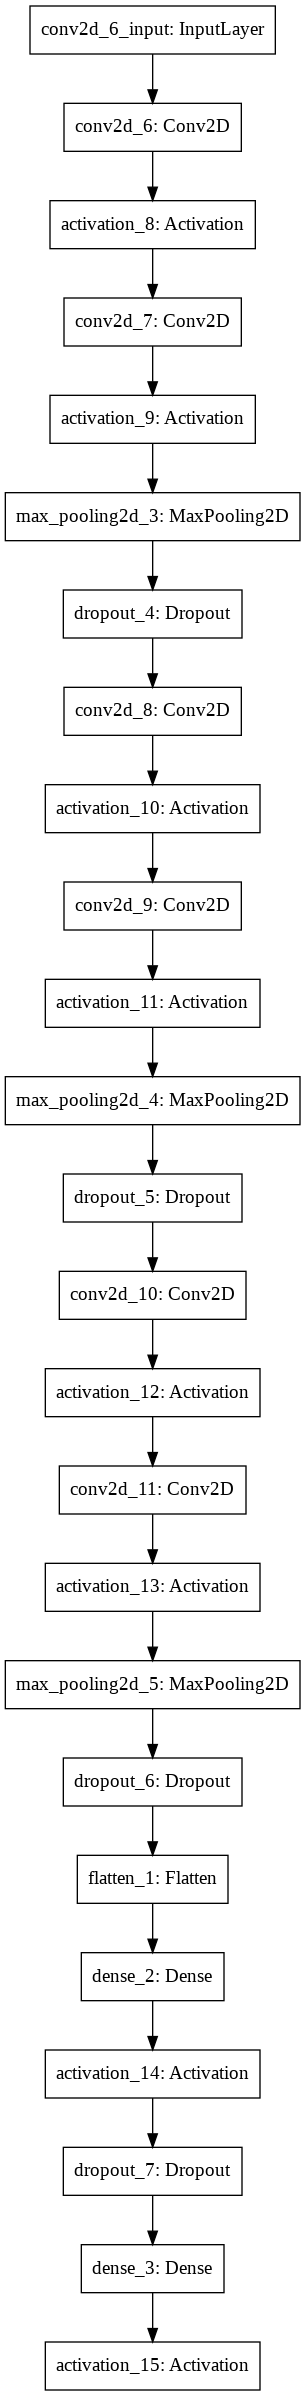

In [19]:
keras.utils.plot_model(model)

# **Compile model**

In [20]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ['accuracy'],
)

# **Train model**

In [21]:
history = model.fit(train_x, train_y, epochs = 40, validation_data = (val_x, val_y))

Epoch 1/40
1250/1250 [==============================] - 62s 49ms/step - loss: 4.1035 - accuracy: 0.0769 - val_loss: 3.5343 - val_accuracy: 0.1712
Epoch 2/40
1250/1250 [==============================] - 61s 49ms/step - loss: 3.4629 - accuracy: 0.1788 - val_loss: 2.9796 - val_accuracy: 0.2805
Epoch 3/40
1250/1250 [==============================] - 61s 49ms/step - loss: 3.0460 - accuracy: 0.2533 - val_loss: 2.6673 - val_accuracy: 0.3321
Epoch 4/40
1250/1250 [==============================] - 61s 49ms/step - loss: 2.7773 - accuracy: 0.3050 - val_loss: 2.4693 - val_accuracy: 0.3783
Epoch 5/40
1250/1250 [==============================] - 61s 49ms/step - loss: 2.5996 - accuracy: 0.3419 - val_loss: 2.3426 - val_accuracy: 0.4018
Epoch 6/40
1250/1250 [==============================] - 61s 49ms/step - loss: 2.4523 - accuracy: 0.3708 - val_loss: 2.2814 - val_accuracy: 0.4189
Epoch 7/40
1250/1250 [==============================] - 61s 49ms/step - loss: 2.3283 - accuracy: 0.3996 - val_loss: 2.1984 -

# **Plot graph**

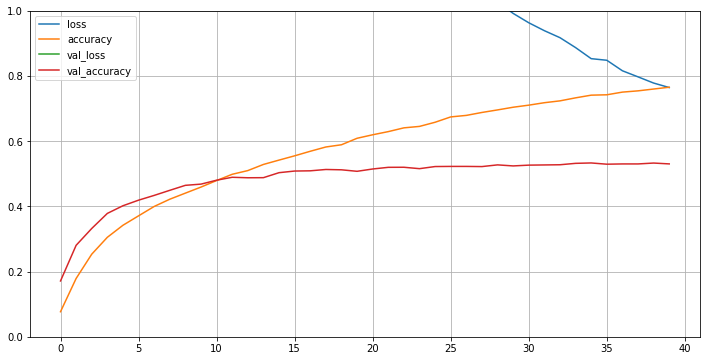

In [25]:
pd.DataFrame(history.history).plot(figsize = (12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# **Evaluate**

In [23]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 5s 16ms/step - loss: 1.9735 - accuracy: 0.5365


[1.973499059677124, 0.5364999771118164]